In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr, spearmanr
from scipy.integrate import quad
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
%matplotlib inline

## Preprocessing

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19 testing data
testing = pd.read_csv('https://covidtracking.com/data/download/california-history.csv')
testing.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-02-01,CA,B,40908.0,NaN,211,NaN,NaN,NaN,15212.0,0,NaN,3949.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3258706,3258706.0,15358,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,42569193,290175,NaN,NaN,NaN,NaN,NaN,0,42569193,290175
1,2021-01-31,CA,B,40697.0,NaN,481,NaN,NaN,NaN,15676.0,0,NaN,4047.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3243348,3243348.0,18974,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,42279018,298562,NaN,NaN,NaN,NaN,NaN,0,42279018,298562
2,2021-01-30,CA,B,40216.0,NaN,638,NaN,NaN,NaN,15941.0,0,NaN,4042.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3224374,3224374.0,18427,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,41980456,303051,NaN,NaN,NaN,NaN,NaN,0,41980456,303051
3,2021-01-29,CA,B,39578.0,NaN,617,NaN,NaN,NaN,16581.0,0,NaN,4232.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3205947,3205947.0,19337,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,41677405,206771,NaN,NaN,NaN,NaN,NaN,0,41677405,206771
4,2021-01-28,CA,B,38961.0,NaN,737,NaN,NaN,NaN,17143.0,0,NaN,4283.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3186610,3186610.0,16696,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,41470634,218152,NaN,NaN,NaN,NaN,NaN,0,41470634,218152


In [3]:
# Hospital data by county if needed
hospital_url = 'https://data.ca.gov/dataset/529ac907-6ba1-4cb7-9aae-8966fc96aeef/resource/42d33765-20fd-44b8-a978-b083b7542225/download/hospitals_by_county.csv'
hospital_df = pd.read_csv(hospital_url)

In [4]:
# recovery data?
testing['recovered'].unique()

array([nan])

In [5]:
testing = testing[['date', 'totalTestResults', 'totalTestResultsIncrease']]
testing.rename(columns={'totalTestResults': 'total_tests', 'totalTestResultsIncrease': 'new_tests'}, inplace=True)
testing = testing.sort_values(by='date', ascending=True).reset_index(drop=True)
testing.head()

,date,total_tests,new_tests
0,2020-03-04,515,0
1,2020-03-05,515,0
2,2020-03-06,522,7
3,2020-03-07,531,9
4,2020-03-08,550,19


In [6]:
# NY Times time series
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes = pd.read_csv(url)
nytimes = nytimes.loc[(nytimes['date'] >= '2020-03-04') &
                      (nytimes['state'] == 'California')].reset_index(drop=True)
nytimes.head()

,date,state,fips,cases,deaths
0,2020-03-04,California,6,55,1
1,2020-03-05,California,6,67,1
2,2020-03-06,California,6,81,1
3,2020-03-07,California,6,100,1
4,2020-03-08,California,6,112,1


In [7]:
# merge testing data and NY Times data
df = pd.merge(testing, nytimes, how='inner', on='date')
df.drop(['state', 'fips'], axis=1, inplace=True)
df.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
df.head()

,date,total_tests,new_tests,total_cases,total_deaths
0,2020-03-04,515,0,55,1
1,2020-03-05,515,0,67,1
2,2020-03-06,522,7,81,1
3,2020-03-07,531,9,100,1
4,2020-03-08,550,19,112,1


In [8]:
# create daily cases and daily deaths columns
df['new_cases'] = df['total_cases'].diff()
df['new_deaths'] = df['total_deaths'].diff()
df.fillna(0, inplace=True)
df['new_cases'] = df['new_cases'].astype('int')
df['new_deaths'] = df['new_deaths'].astype('int')
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-04,515,0,55,1,0,0
1,2020-03-05,515,0,67,1,12,0
2,2020-03-06,522,7,81,1,14,0
3,2020-03-07,531,9,100,1,19,0
4,2020-03-08,550,19,112,1,12,0


In [9]:
# add positivity rate column
df['positivity_rate'] = df['total_cases']/df['total_tests']
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


In [10]:
df.to_csv('california_covid19.csv')
print(df.shape)
df.head()

(335, 8)


,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


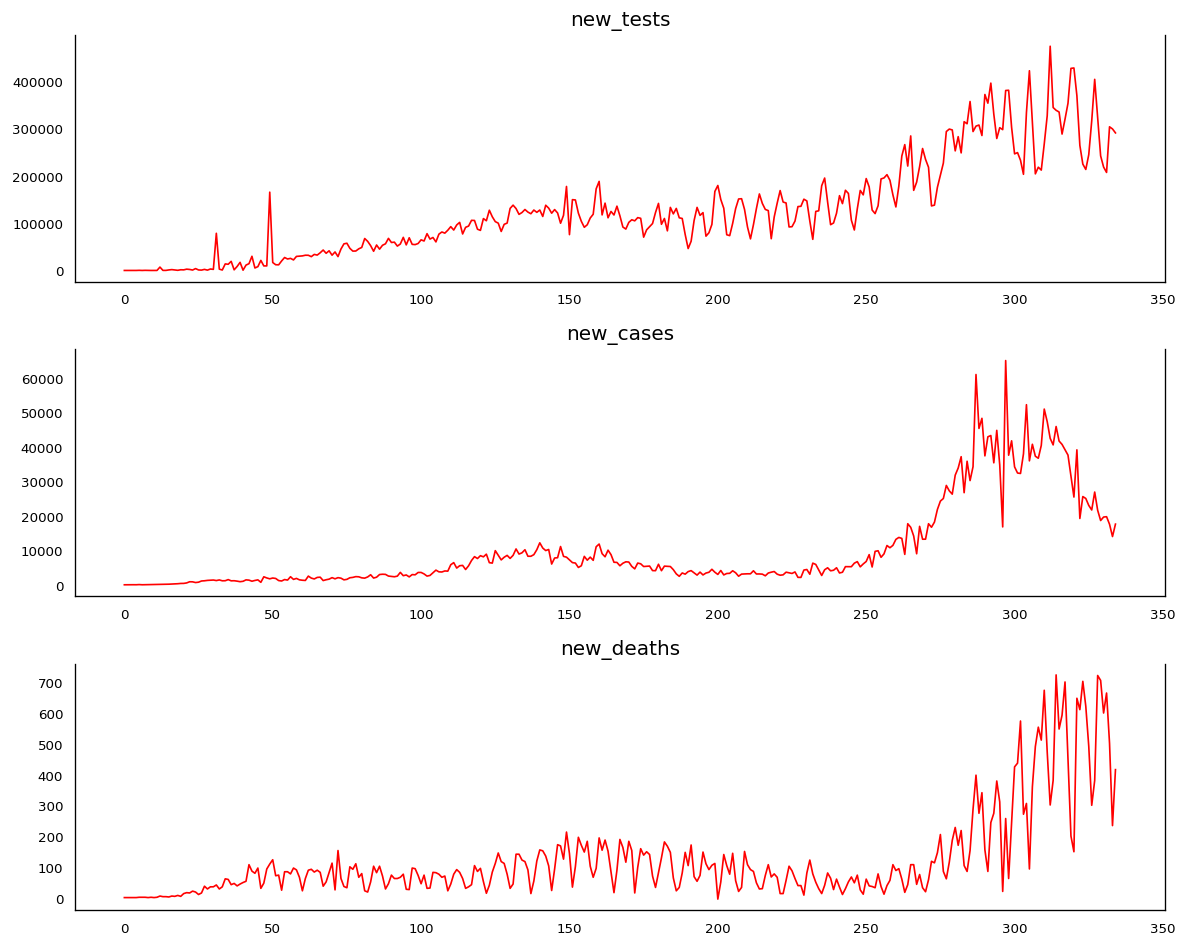

In [11]:
plot_df = df.loc[:, ['new_tests', 'new_cases', 'new_deaths']]
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,8))
plt.rc('font', size=10)
for i, ax in enumerate(axes.flatten()): 
    data = plot_df[plot_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(plot_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.tight_layout()

## Correlation

In [12]:
# Our null hypothesis is that the correlation coefficient is not significantly different from 0.
def pearson_corr(column1, column2):
    corr_coef, p_value = pearsonr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)

def spearman_corr(column1, column2):
    corr_coef, p_value = spearmanr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)
    
pearson_corr(df['new_cases'], df['new_deaths'])

correlation: 0.7035792004718457
p value: 2.4343798728471352e-51


P-value is less than 0.05, so we can conclude there is a positive correlation between new deaths and new cases.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


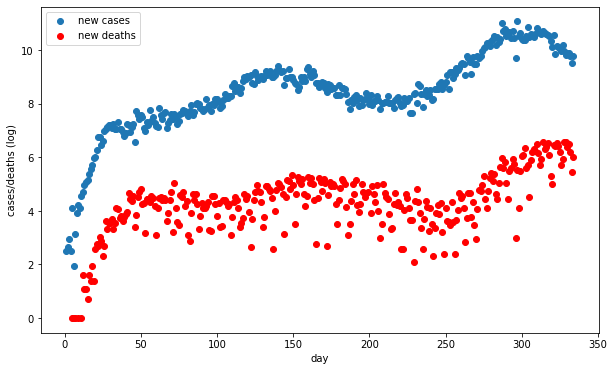

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, len(df)), np.log(df['new_cases']), label='new cases')
plt.scatter(np.arange(0, len(df)), np.log(df['new_deaths']), label='new deaths', c='red')
plt.legend()
plt.xlabel('day')
plt.ylabel('cases/deaths (log)')
plt.show()

In [14]:
pearson_corr(df['positivity_rate'], df['total_deaths'])

correlation: -0.3703234635665061
p value: 2.5010017975631495e-12


In [15]:
df.corr(method='spearman')

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
total_tests,1.000000,0.921228,1.000000,0.999998,0.841518,0.539473,-0.413571
new_tests,0.921228,1.000000,0.921226,0.921220,0.877093,0.500210,-0.360904
total_cases,1.000000,0.921226,1.000000,0.999998,0.841519,0.539474,-0.413568
total_deaths,0.999998,0.921220,0.999998,1.000000,0.841528,0.539551,-0.413591
new_cases,0.841518,0.877093,0.841519,0.841528,1.000000,0.651022,-0.288195
new_deaths,0.539473,0.500210,0.539474,0.539551,0.651022,1.000000,0.078531
positivity_rate,-0.413571,-0.360904,-0.413568,-0.413591,-0.288195,0.078531,1.000000


## VAR

In [16]:
deaths_df = df[['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']]
deaths_df.shape

(335, 5)

In [17]:
log_df = df[['total_cases', 'total_deaths', 'total_tests', 'positivity_rate']]
log_df.head()

,total_cases,total_deaths,total_tests,positivity_rate
0,55,1,515,0.106796
1,67,1,515,0.130097
2,81,1,522,0.155172
3,100,1,531,0.188324
4,112,1,550,0.203636


In [18]:
warnings.filterwarnings('ignore')

# apply log transform
log_df['total_cases'] = np.log(log_df['total_cases'])
log_df['total_deaths'] = np.log(log_df['total_deaths'])
log_df['total_tests'] = np.log(log_df['total_tests'])
log_df.head()

,total_cases,total_deaths,total_tests,positivity_rate
0,4.007333,0.0,6.244167,0.106796
1,4.204693,0.0,6.244167,0.130097
2,4.394449,0.0,6.257668,0.155172
3,4.605170,0.0,6.274762,0.188324
4,4.718499,0.0,6.309918,0.203636


In [19]:
train, test = np.split(log_df, [int(.95 *len(log_df))]) # 95% train data
print(train.shape, test.shape)

(318, 4) (17, 4)


In [20]:
# fit VAR model and forecast
deaths_model = VAR(train)
model_fit = deaths_model.fit()
cols = ['total_cases', 'total_deaths', 'total_tests', 'positivity_rate']
pred_df = pd.DataFrame(model_fit.forecast(model_fit.y, steps=len(test)), columns=cols)

# exponentiate data
pred_df['total_cases'] = np.exp(pred_df['total_cases']).astype('int')
pred_df['total_deaths'] = np.exp(pred_df['total_deaths']).astype('int')
pred_df['total_tests'] = np.exp(pred_df['total_tests']).astype('int')
pred_df.head()

,total_cases,total_deaths,total_tests,positivity_rate
0,2960805,33446,36647676,0.084467
1,2984236,34044,36351541,0.088189
2,3006786,34702,36392128,0.090278
3,3027851,35391,36658122,0.091214
4,3047026,36092,37073720,0.091344


In [21]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Feb, 2021
Time:                     14:28:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -29.4646
Nobs:                     317.000    HQIC:                  -29.6070
Log likelihood:           2928.52    FPE:                1.26094e-13
AIC:                     -29.7018    Det(Omega_mle):     1.18442e-13
--------------------------------------------------------------------
Results for equation total_cases
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.082404         0.038228            2.156           0.031
L1.total_cases             1.019258         0.013023           78.266           0.000
L1.total_deaths           -0.04941

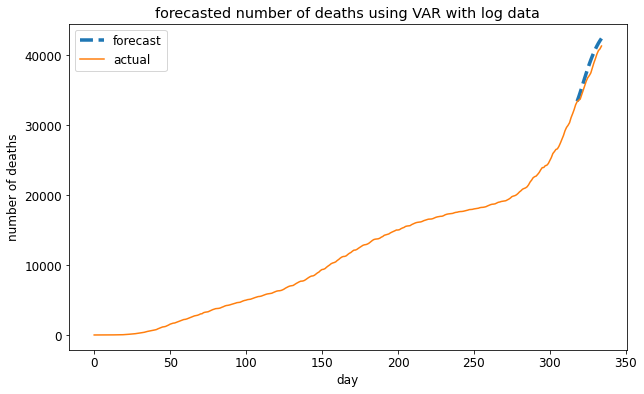

In [22]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train), len(train)+len(test)), pred_df['total_deaths'], 
         '--', label='forecast', linewidth=3.5)
plt.plot(np.arange(0, len(log_df)), deaths_df['total_deaths'], label='actual')
plt.xlabel('day')
plt.ylabel('number of deaths')
plt.title('forecasted number of deaths using VAR with log data')
plt.legend()
plt.show()

https://numpy.org/doc/stable/reference/generated/numpy.trapz.html

In [23]:
# pred_df['total_cases'] = np.exp(np.trapz(pred_df['total_cases']))
# pred_df['total_deaths'] = np.exp(np.trapz(pred_df['total_deaths']))
# pred_df['total_tests'] = np.exp(np.trapz(pred_df['total_tests']))
# pred_df.head()

## ARIMA

### Forecast 1 day at a time

In [24]:
x = deaths_df['total_deaths']
size = int(len(x) * 0.7)
train, test = x[0:size], x[size:len(x)]
print(train.shape, test.shape)

(234,) (101,)


https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

order = (3,1,0) sets the lag value to 3 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0

In [25]:
history = [i for i in train]
pred = []
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast() # perform 1 step forecast
    yhat = output[0]
    pred.append(yhat)
    obs = np.array(test)[t]
    history.append(obs)

In [26]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1918.032
Date:                Tue, 02 Feb 2021   AIC                           3844.065
Time:                        14:28:48   BIC                           3859.297
Sample:                             0   HQIC                          3850.139
                                - 334                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8407      0.036     23.327      0.000       0.770       0.911
ar.L2         -0.0744      0.038     -1.980      0.048      -0.148      -0.001
ar.L3          0.1683      0.027      6.195      0.000       0.115       0.222
sigma2      5861.8459    229.124     25.584      0.000    5412.772    6310.920
===================================================================================
Ljung-Box (Q):                      588.00   Jarque-Bera (JB):               750.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.41   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
def metrics(test, pred):  
    mae = mean_absolute_error(test, pred)
    rmse = math.sqrt(mean_squared_error(test, pred))
    r2 = r2_score(test, pred)
    print('mae:', mae)
    print('rmse:', rmse)
    print('r2:', r2)

metrics(test, pred)

mae: 92.76297623453797
rmse: 130.9897378377111
r2: 0.9996595819401991


In [28]:
data = {'actual': test, 'prediction': pred, 'diff': test-pred}
pred_df = pd.DataFrame(data)
pred_df['upper'] = pred_df['prediction'] + 1.96*pred_df['diff']
pred_df['lower'] = pred_df['prediction'] - 1.96*pred_df['diff']
pred_df

,actual,prediction,diff,upper,lower
234,17345,17377.583827,-32.583827,17313.719526,17441.448129
235,17358,17381.179925,-23.179925,17335.747272,17426.612577
236,17398,17377.270494,20.729506,17417.900326,17336.640661
237,17478,17437.384530,40.615470,17516.990851,17357.778210
238,17541,17540.532355,0.467645,17541.448939,17539.615772
...,...,...,...,...,...
330,39527,39540.540190,-13.540190,39514.001418,39567.078963
331,40192,40112.397885,79.602115,40268.418030,39956.377741
332,40694,40838.549629,-144.549629,40555.232356,41121.866902
333,40928,41178.032201,-250.032201,40687.969087,41668.095314


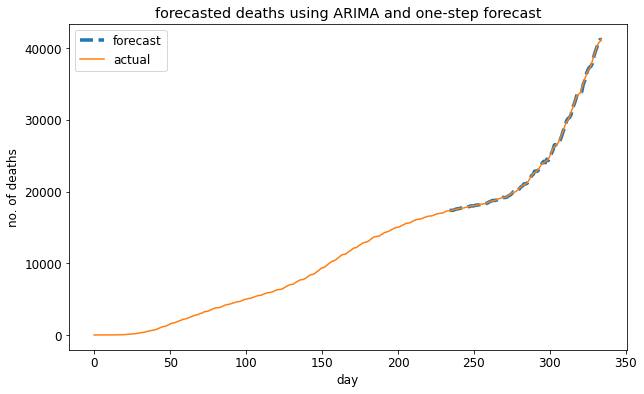

In [29]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train), len(train)+len(pred)), pred, '--', label='forecast', linewidth=3.5)
plt.plot(np.arange(0, len(x)), x, label='actual')
plt.xlabel('day')
plt.ylabel('no. of deaths')
plt.title('forecasted deaths using ARIMA and one-step forecast')
plt.legend()
plt.show()

### Forecast a certain number of days at once

In [30]:
x = deaths_df['total_deaths']

def split_data(split_size):
    size = int(len(x) * split_size)
    train, test = x[0:size], x[size:len(x)]
    print(train.shape, test.shape)
    return train, test

def arima(train, test):
    model = ARIMA(train, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=len(test))
    return output

def plot_pred(train, output, title):
    plt.figure(figsize=(8,5))
    plt.rcParams.update({'font.size': 12})
    plt.plot(np.arange(len(train), len(train)+len(output)), output, '--', label='forecast', linewidth=3)
    plt.plot(np.arange(0, len(x)), x, label='actual')
    plt.xlabel('day')
    plt.ylabel('number of deaths')
    plt.title(title)
    plt.legend()
    plt.show()

In [31]:
train1, test1 = split_data(0.6)
train2, test2 = split_data(0.7)
train3, test3 = split_data(0.8)
train4, test4 = split_data(0.9)
train5, test5 = split_data(0.95)


arima1 = arima(train1, test1)
arima2 = arima(train2, test2)
arima3 = arima(train3, test3)
arima4 = arima(train4, test4)
arima5 = arima(train5, test5)

(201,) (134,)
(234,) (101,)
(268,) (67,)
(301,) (34,)
(318,) (17,)


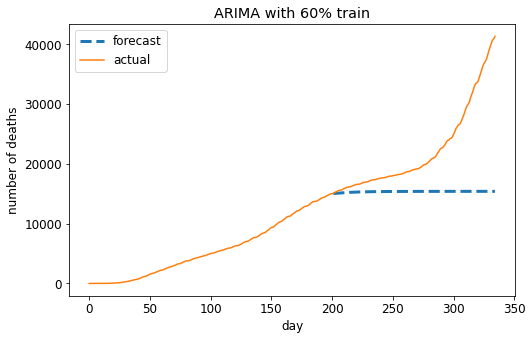

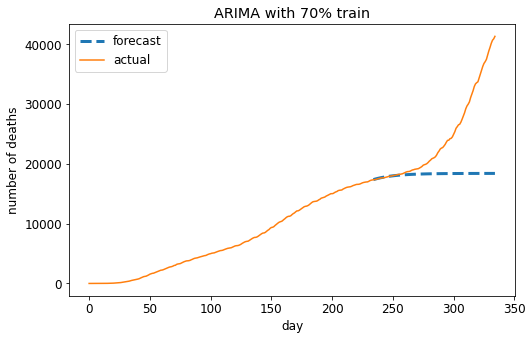

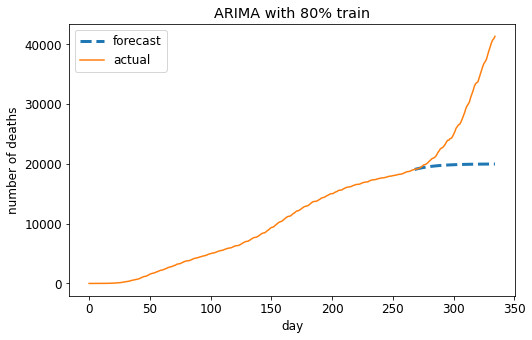

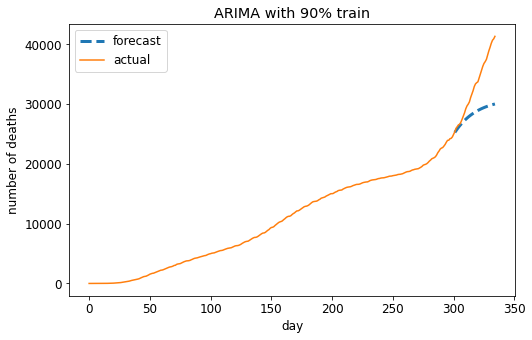

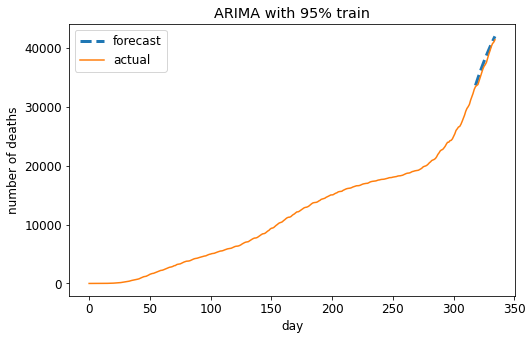

In [32]:
plot_pred(train1, arima1, 'ARIMA with 60% train')
plot_pred(train2, arima2, 'ARIMA with 70% train')
plot_pred(train3, arima3, 'ARIMA with 80% train')
plot_pred(train4, arima4, 'ARIMA with 90% train')
plot_pred(train5, arima5, 'ARIMA with 95% train')

In [33]:
metrics(test5, arima5)

mae: 762.5029343828184
rmse: 810.2842871082718
r2: 0.9046405946971575


### Forecast the future

In [34]:
# fit model with normal data
model = ARIMA(deaths_df['total_deaths'], order=(3,1,0))
fit = model.fit()
pred = fit.forecast(steps=60)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_deaths   No. Observations:                  335
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1924.946
Date:                Tue, 02 Feb 2021   AIC                           3857.891
Time:                        14:28:49   BIC                           3873.136
Sample:                             0   HQIC                          3863.969
                                - 335                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8234      0.035     23.329      0.000       0.754       0.893
ar.L2         -0.0680      0.037     -1.815      0.069      -0.141       0.005
ar.L3          0.1849      0.027      6.945      0.000       0.133       0.237
sigma2      5901.6306    230.894     25.560      0.000    5449.086    6354.175
===================================================================================
Ljung-Box (Q):                      616.83   Jarque-Bera (JB):               683.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.76   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# fit model with log data
log_model = ARIMA(np.log(deaths_df['total_deaths']), order=(3,1,0))
log_fit = log_model.fit()
log_pred = log_fit.forecast(steps=60)
exp_pred = np.exp(log_pred)
log_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_deaths   No. Observations:                  335
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 494.353
Date:                Tue, 02 Feb 2021   AIC                           -980.706
Time:                        14:28:49   BIC                           -965.462
Sample:                             0   HQIC                          -974.628
                                - 335                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5298      0.034     15.563      0.000       0.463       0.597
ar.L2          0.1538      0.036      4.291      0.000       0.084       0.224
ar.L3          0.0966      0.027      3.544      0.000       0.043       0.150
sigma2         0.0030   3.55e-05     85.299      0.000       0.003       0.003
===================================================================================
Ljung-Box (Q):                      129.77   Jarque-Bera (JB):            124566.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             7.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        96.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

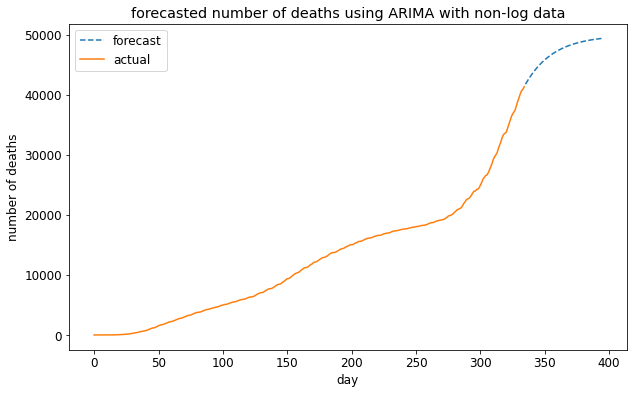

In [36]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(deaths_df), len(deaths_df)+len(pred)), pred, '--', label='forecast')
plt.plot(np.arange(0, len(deaths_df)), x, label='actual')
plt.xlabel('day')
plt.ylabel('number of deaths')
plt.title('forecasted number of deaths using ARIMA with non-log data')
plt.legend()
plt.show()

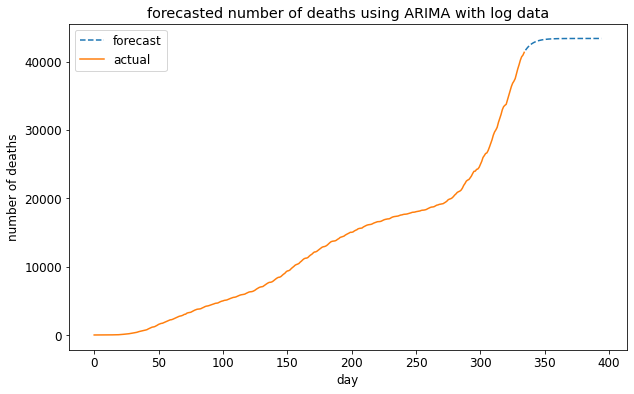

In [37]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(deaths_df), len(deaths_df)+len(exp_pred)), exp_pred, '--', label='forecast')
plt.plot(np.arange(0, len(x)), x, label='actual')
plt.xlabel('day')
plt.ylabel('number of deaths')
plt.title('forecasted number of deaths using ARIMA with log data')
plt.legend()
plt.show()